In [1]:
import pennylane as qml
from pennylane import numpy as np
from Qsun.Qcircuit import *
from Qsun.Qgates import *
import time

# Quantum Machine Learning

In [2]:
import matplotlib.pyplot as plt
# import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
X, y = datasets.load_diabetes(return_X_y=True)
y = (y - np.min(y)) / (np.max(y) - np.min(y))
# Use only one feature
X = X[:, np.newaxis, 2]

# Split the data into training/testing sets
X_train = X[:400]
X_test = X[-10:]

# Split the targets into training/testing sets
y_train = y[:400]
y_test = y[-10:]

In [46]:
feature_matrix = np.hstack((X_train, np.ones((len(X_train), 1))))

In [47]:
theta = np.dot(feature_matrix.T, feature_matrix)
theta = np.linalg.inv(theta)
theta = np.dot(theta, feature_matrix.T)
theta = np.dot(theta, y_train)
theta

array([2.97726802, 0.39875447])

In [48]:
test_matrix = np.hstack((X_test, np.ones((len(X_test), 1))))

In [49]:
y_pred_exact = np.dot(test_matrix, theta)

In [50]:
mean_squared_error(y_test, y_pred_exact)

0.020474527452362286

### Classic

In [8]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients: 
 [2.97726802]
Intercept: 
 0.3987544671550144
Mean squared error: 0.02
Coefficient of determination: 0.40


In [10]:
mean_squared_error(y_test, y_pred)

0.020474527452362327

### QVM 

In [11]:
from Qsun.Qcircuit import *
from Qsun.Qgates import *

In [62]:
def circuit(params):
    c = Qubit(1)
    RX(c, 0, params[0])
    RY(c, 0, params[1])
    return c

def output(params):
    c = circuit(params)
    prob = c.probabilities()
    return 1*prob[0] - 1*prob[1]

def predict(x_true, coef_params, intercept_params, boundary=10):
    coef = boundary*output(coef_params)
    intercept = boundary*output(intercept_params)
    return coef*x_true.flatten() + intercept

def errors(x_true, y_true, coef_params, intercept_params, boundary):
    return mean_squared_error(y_true, predict(x_true, coef_params, intercept_params, boundary))

def grad(x_true, y_true, coef_params, intercept_params, shift, eta, boundary):
    
    coef_diff = np.zeros((2,))
    intercept_diff = np.zeros((2,))
    
    for i in range(len(coef_params)):
        coef_params_1 = coef_params.copy()
        coef_params_2 = coef_params.copy()
        coef_params_1[i] += shift
        coef_params_2[i] -= shift
        for x, y in zip(x_true, y_true):
            coef_diff[i] -= x*(y-predict(x, coef_params, intercept_params, boundary))*(output(coef_params_1)-output(coef_params_2))/(2*np.sin(shift))
            
        
    for i in range(len(coef_params)):
        intercept_params_1 = intercept_params.copy()
        intercept_params_2 = intercept_params.copy()
        intercept_params_1[i] += shift
        intercept_params_2[i] -= shift
        for x, y in zip(x_true, y_true):
            intercept_diff[i] -= (y-predict(x, coef_params, intercept_params, boundary))*(output(intercept_params_1)-output(intercept_params_2))/(2*np.sin(shift))
     
    coef_diff = coef_diff*boundary*2/len(y_true)
    intercept_diff = intercept_diff*boundary*2/len(y_true)
    
    for i in range(len(coef_params)):
        coef_params[i] = coef_params[i] - eta*coef_diff[i]
        
    for i in range(len(intercept_params)):
        intercept_params[i] = intercept_params[i] - eta*intercept_diff[i]
        
    return coef_params, intercept_params

In [52]:
# params = np.random.normal(size=(4,))
# circuit(params).visual_circuit()

In [63]:
# # before training
coef_params = np.array([-1.03295171, -0.64020581])
intercept_params = np.array([ 0.84085179, -0.5721947 ])

In [54]:
# coef_params = np.random.normal(size=(2,))
# intercept_params = np.random.normal(size=(2,))

In [64]:
start = time.time()
costs_train_qlr = []
costs_test_qlr = []
for i in range(1000):
    coef_params, intercept_params = grad(X_train, y_train, coef_params, intercept_params, np.pi/20, eta=0.1, boundary=10)
#     costs_train_qlr.append(errors(X_train, y_train, coef_params, intercept_params, boundary))
#     costs_test_qlr.append(errors(X_test, y_test, coef_params, intercept_params, boundary))
end = time.time()  

In [65]:
coef_params, intercept_params

(array([-1.17237395, -0.69600957]), array([-1.77178729, -4.51130017]))

In [57]:
# # after training
# coef_params = np.array([-1.16054864, -0.69170808])
# intercept_params = np.array([ 1.50226492, -0.94915154])

In [58]:
print(end-start)

193.40120768547058


### PennyLane

In [20]:
import autograd.numpy as np_grad

In [21]:
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def circuit_qml(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RX(params[2], wires=1)
    qml.RY(params[3], wires=1)
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))

def cost(params):
    expval = circuit_qml(params)
    coef = boundary*expval[0]
    intercept = boundary*expval[1]
    y_pred_qml = coef*X_train.flatten() + intercept
    return np_grad.mean((y_train-y_pred_qml)**2)

In [29]:
boundary = 10
params = np.random.normal(size=(4,))
opt = qml.GradientDescentOptimizer()
steps = 1000

In [30]:
params = np.random.normal(size=(4,))
cost(params)

tensor(0.27294871, requires_grad=True)

In [31]:
start = time.time()
for i in range(steps):
    params = opt.step(cost, params)   
end = time.time()

In [32]:
expval = circuit_qml(params)
coef = boundary*expval[0]
intercept = boundary*expval[1]
y_pred_qml = coef*X_test.flatten() + intercept

In [33]:
end-start

3.1526029109954834

In [34]:
# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
SIZE = 34*1.3

plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)  # fontsize of the figure title

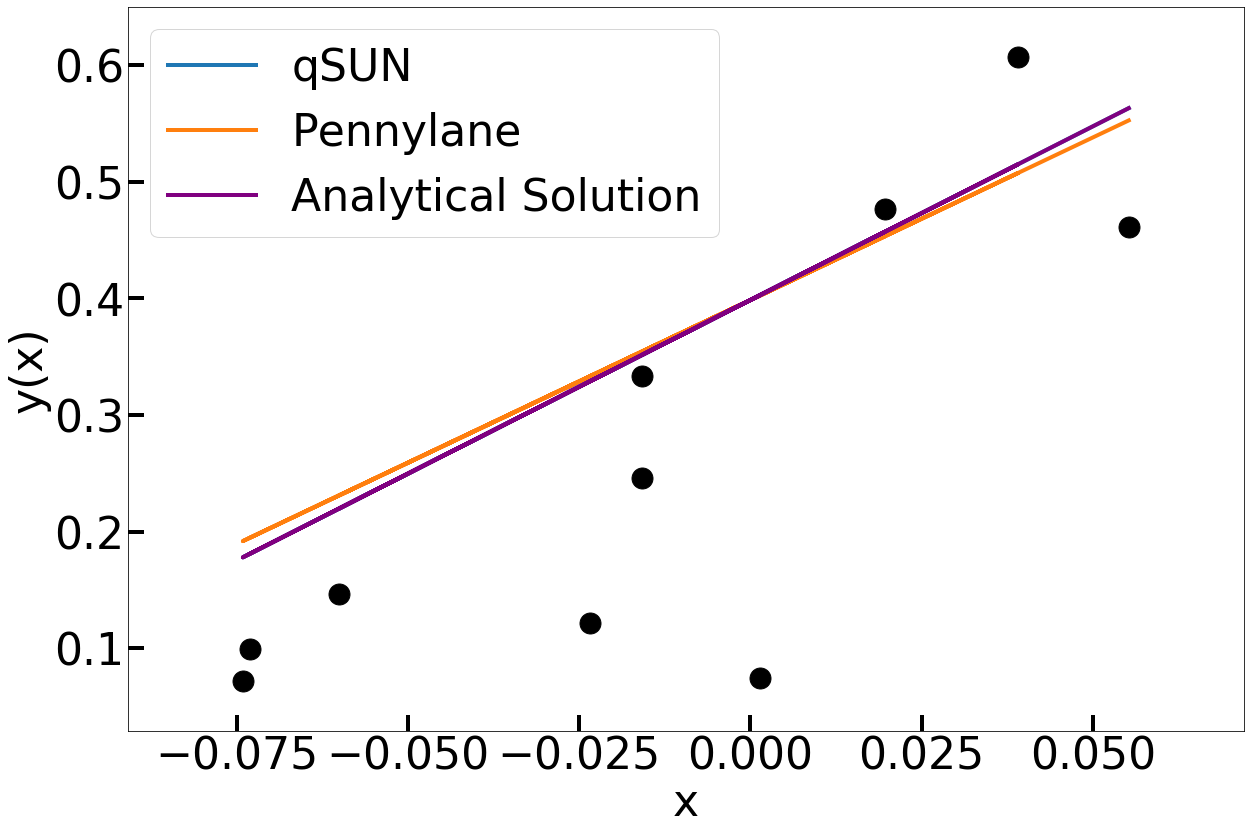

In [66]:
plt.figure(figsize=(20,13.33))
plt.scatter(X_test, y_test, s=440, color='black', )
plt.plot(X_test, predict(X_test, coef_params, intercept_params, boundary=10), linewidth=4, label='qSUN')
plt.plot(X_test, y_pred_qml, linewidth=4, label='Pennylane')
plt.plot(X_test, y_pred_exact, linewidth=4, label='Analytical Solution', color='purple')
# plt.plot(X_test, predict(X_test, coef_params, intercept_params, boundary=10), 'o--', linewidth=4, markersize=24, label='qSUN')
# plt.plot(X_test, y_pred_qml, 'v--', linewidth=4, markersize=24, label='Pennylane')
# plt.plot(X_test, y_pred, 'd--', linewidth=4, markersize=24, label='scikit-learn', color='purple')
plt.tick_params(axis="x", which = 'major', direction="in", length=16, width=4)
plt.tick_params(axis="y", which = 'major', direction="in", length=16, width=4)
plt.tick_params(axis="y", which = 'minor', direction="in", length=8, width=4)
plt.xlabel('x')
plt.ylabel('y(x)')
plt.legend()
plt.savefig('compare_linear_regression_new.png')
plt.savefig('compare_linear_regression_new.eps', format='eps')

In [67]:
mean_squared_error(y_test, y_pred_exact), mean_squared_error(y_test, predict(X_test, coef_params, intercept_params, boundary=10)), mean_squared_error(y_test, y_pred_qml)

(0.020474527452362286, 0.020474527452292078, 0.021400375081775523)

# Optimize cost function

### PennyLane

In [20]:
# for i in range(1, 6):
#     print(i)
#     for j in range(0, 2*i, 2):
#         print(j, j//2)
#         print(j+1, j//2)

In [3]:
dev = qml.device('default.qubit', wires=1)

@qml.qnode(dev)
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    return qml.expval(qml.PauliZ(0))

def cost(params):
    expval = circuit(params)
    return np.abs(expval - (-1))**2

start = time.time()
params = np.random.normal(size=(2,))
opt = qml.GradientDescentOptimizer()
steps = 400

for i in range(steps):
    params = opt.step(cost, params)
end = time.time()

print('Circuit output:', circuit(params))
print('Final parameter:', params)
print('Time:', end-start)

Circuit output: -0.9321125210854404
Final parameter: [ 0.06068427 -2.77577461]
Time: 0.6734745502471924


### QVM

In [4]:
def circuit(params):
    c = Qubit(1)
    RX(c, 0, params[0])
    RY(c, 0, params[1])
    return c

def output(params):
    c = circuit(params)
    prob = c.probabilities()
    return 0.*prob[0] + 1*prob[1]
    
def cost(params):
    expval = output(params)
    return np.abs(expval - 1)**2

def grad(params, shift, eta):
    for i in range(len(params)):
        params_1 = params.copy()
        params_2 = params.copy()
        params_1[i] += shift
        params_2[i] -= shift
        diff[i] = (cost(params_1)-cost(params_2))/(2*np.sin(shift))
    for i in range(len(params)):
        params[i] = params[i] - eta*diff[i]
    return params

start = time.time()    
params = np.random.normal(size=(2,))
diff = np.random.normal(size=(2,))

for i in range(1000):
    params = grad(params, np.pi/20, eta=0.01)
end = time.time()    
    
print('Circuit output:', output(params))
print('Final parameter:', params)
print('Time:', end-start)

Circuit output: 0.9121365398178807
Final parameter: [-2.63810441  0.34506581]
Time: 0.1436152458190918


# Test with n-qubit

In [13]:
n = 10

### Pennylane

In [3]:
dev = qml.device('default.qubit', wires=10)

@qml.qnode(dev)
def circuit(params, n):
    for j in range(0, 2*n, 2):
        qml.RX(params[j], wires=j//2)
        qml.RY(params[j+1], wires=j//2)
    return qml.probs(wires=range(n))

def cost(params):
    prob = circuit(params, len(params)//2)
    return -np.sum([i*prob[i] for i in range(len(prob))])


time_qml = []

for i in range(1, n+1):
    
    start = time.time()
    params = np.random.normal(size=(2*i,))
    opt = qml.GradientDescentOptimizer()
    steps = 1000

    for i in range(steps):
        params = opt.step(cost, params)
    end = time.time()
    
    time_qml.append(end-start)
    print(cost(params))

-0.9997366051185961
-2.99984394580364
-6.999709653891164
-14.999707407103218
-30.997589217962666
-62.976873045500476
-126.99969081842032
-254.98879636113793
-510.88341389647815
-862.9117645162539


### QVM

In [4]:
def circuit(params, n):
    c = Qubit(n)
    for j in range(0, 2*n, 2):
        RX(c, j//2, params[j])
        RY(c, j//2, params[j+1])
    return c

def output(params):
    c = circuit(params, len(params)//2)
    prob = c.probabilities()
    return -np.sum([i*prob[i] for i in range(len(prob))])
    
def cost(params):
    expval = output(params)
    return expval

def grad(params, shift, eta):
    for i in range(len(params)):
        params_1 = params.copy()
        params_2 = params.copy()
        params_1[i] += shift
        params_2[i] -= shift
        diff[i] = (cost(params_1)-cost(params_2))/(2*np.sin(shift))
    for i in range(len(params)):
        params[i] = params[i] - eta*diff[i]
    return params

time_qvm = []
for i in range(1, n+1):

    start = time.time()    
    params = np.random.normal(size=(2*i,))
    diff = np.random.normal(size=(2*i,))

    for i in range(1000):
        params = grad(params, np.pi/20, eta=0.01)
    end = time.time() 
    
    time_qvm.append(end-start)
    print(cost(params))

-0.9999729911341415
-2.9998269822235395
-6.999847653930985
-14.99980594303604
-30.99998164531647
-62.988618074166105
-126.49185021495407
-254.9998577970375
-510.9999706605911
-862.9078125034878


In [5]:
import pandas as pd

df = pd.DataFrame({'QVM': time_qvm, 'PennyLane': time_qml}, range(1, n+1))
df

,QVM,PennyLane
1,0.187351,1.787268
2,0.612240,2.806498
3,1.537565,4.406220
4,3.499247,5.749630
5,8.135257,8.119293
6,20.392124,12.493603
7,39.956043,18.496281
8,89.475054,31.079915
9,203.616042,58.159524
10,442.021693,118.550235


In [6]:
df.to_csv('qcd.csv')

In [9]:
df = pd.read_csv('qcd.csv')

In [10]:
# df['QVM'] = np.log(df['QVM'])
# df['PennyLane'] = np.log(df['PennyLane'])
# df

In [11]:
# plt.rcParams['mathtext.fontset'] = 'cm'
# plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
# plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
# plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

In [8]:
# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
SIZE = 34*1.3

plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)  # fontsize of the figure title

C:\Users\ASUS\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  # This is added back by InteractiveShellApp.init_path()


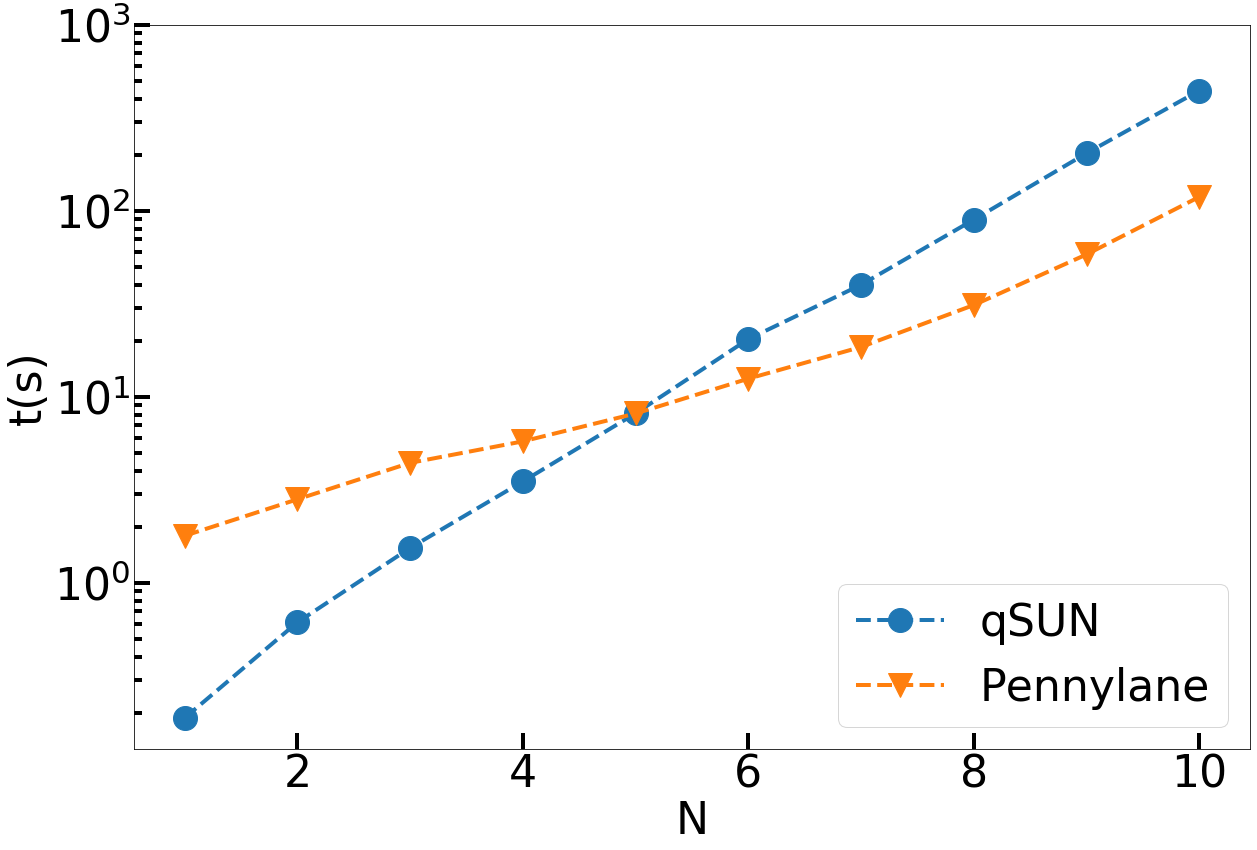

In [14]:
plt.figure(figsize=(20,13.33))
plt.plot(range(1, n+1), df['QVM'], 'o--', linewidth=4, markersize=24, label='qSUN')
plt.plot(range(1, n+1), df['PennyLane'], 'v--', linewidth=4, markersize=24, label='Pennylane')
plt.tick_params(axis="x", which = 'major', direction="in", length=16, width=4)
plt.tick_params(axis="y", which = 'major', direction="in", length=16, width=4)
plt.tick_params(axis="y", which = 'minor', direction="in", length=8, width=4)
plt.yscale('log')
plt.xlabel('N')
plt.legend(loc='lower right')
plt.ylabel('t(s)')
plt.ylim(plt.ylim([0, 1000]))
plt.savefig('compare_time_QCD.png')
plt.savefig('compare_time_QCD.eps', format='eps')

# Test with depth

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [6]:
qubit_min = 2
qubit_max = 15
depth = 10

In [13]:
def qvm_circuit(n_qubit, depth):
    circuit = Qubit(n_qubit)
    for m in range(depth):
        for i in range(n_qubit):
            H(circuit, i)
            Xsquare(circuit, i)
        for i in range(1, n_qubit):
            CNOT(circuit, i, 0)
    return circuit.probabilities()

In [14]:
dev = qml.device('default.qubit', wires=qubit_max)

@qml.qnode(dev)
def qml_circuit(n_qubit, depth):
    for m in range(depth):
        for i in range(n_qubit):
            qml.Hadamard(wires=i)
            qml.SX(wires=i)
        for i in range(1, n_qubit):
            qml.CNOT(wires=[i, 0])
    return qml.probs(wires=range(n_qubit))

In [15]:
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

def qiskit_circuit(n_qubit, depth):
    qr = QuantumRegister(n_qubit)
    cr = ClassicalRegister(n_qubit)
    circuit = QuantumCircuit(qr, cr)
    for m in range(depth):
        for i in range(n_qubit):
            circuit.h(qr[i])
            circuit.rx(math.pi/2, qr[i])
        for i in range(1, n_qubit):
            circuit.cx(qr[i], qr[0])
    circuit.measure_all()
    backend = BasicAer.get_backend('qasm_simulator')
    result = execute(circuit, backend=backend, shots=1024).result()
    return result.get_counts(circuit)

In [16]:
from projectq import MainEngine
import projectq.ops as ops
from projectq.backends import Simulator

def projectq_circuit(n_qubit, depth):
    eng = MainEngine(backend=Simulator(gate_fusion=True),engine_list=[])
    qbits = eng.allocate_qureg(n_qubit)
    for level in range(depth):
        for q in qbits:
            ops.H|q
            ops.SqrtX|q
            if q != qbits[0]:
                ops.CNOT|(q,qbits[0])
    for q in qbits:
        ops.Measure|q
    eng.flush()

In [57]:
data_qvm = []

for n_qubit in range(qubit_min, qubit_max):
    start = time.time()
    qvm_circuit(n_qubit, depth)
    end = time.time()
    data_qvm.append(end-start)

In [58]:
data_qml = []

for n_qubit in range(qubit_min, qubit_max):
    start = time.time()
    qml_circuit(n_qubit, depth)
    end = time.time()
    data_qml.append(end-start)

In [59]:
data_qiskit = []

for n_qubit in range(qubit_min, qubit_max):
    start = time.time()
    qiskit_circuit(n_qubit, depth)
    end = time.time()
    data_qiskit.append(end-start)

In [60]:
data_projectq = []

for n_qubit in range(qubit_min, qubit_max):
    start = time.time()
    projectq_circuit(n_qubit, depth)
    end = time.time()
    data_projectq.append(end-start)

# data_projectq

(Note: This is the (slow) Python simulator.)
(Note: This is the (slow) Python simulator.)
(Note: This is the (slow) Python simulator.)
(Note: This is the (slow) Python simulator.)
(Note: This is the (slow) Python simulator.)
(Note: This is the (slow) Python simulator.)
(Note: This is the (slow) Python simulator.)
(Note: This is the (slow) Python simulator.)
(Note: This is the (slow) Python simulator.)
(Note: This is the (slow) Python simulator.)
(Note: This is the (slow) Python simulator.)
(Note: This is the (slow) Python simulator.)
(Note: This is the (slow) Python simulator.)


In [61]:
df = pd.DataFrame({'QVM': data_qvm, 'PennyLane': data_qml, 
                   'Qiskit': data_qiskit, 'ProjectQ': data_projectq}, index = range(qubit_min, qubit_max))
df

,QVM,PennyLane,Qiskit,ProjectQ
2,0.000998,0.023936,0.023936,0.004981
3,0.000997,0.023936,0.027926,0.009977
4,0.001995,0.030917,0.034906,0.011964
5,0.005982,0.040891,0.043883,0.017952
6,0.011970,0.048869,0.052865,0.025930
7,0.027924,0.056848,0.060830,0.048870
8,0.047872,0.065824,0.068826,0.071807
9,0.114588,0.075798,0.079778,0.139628
10,0.225754,0.082778,0.091754,0.315157
11,0.526934,0.093750,0.115691,0.657241


In [62]:
# df = np.log(df)
df.to_csv('compare.csv')

In [3]:
df = pd.read_csv('compare.csv')

In [4]:
# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
SIZE = 34*1.3

plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels

plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)  # fontsize of the figure title

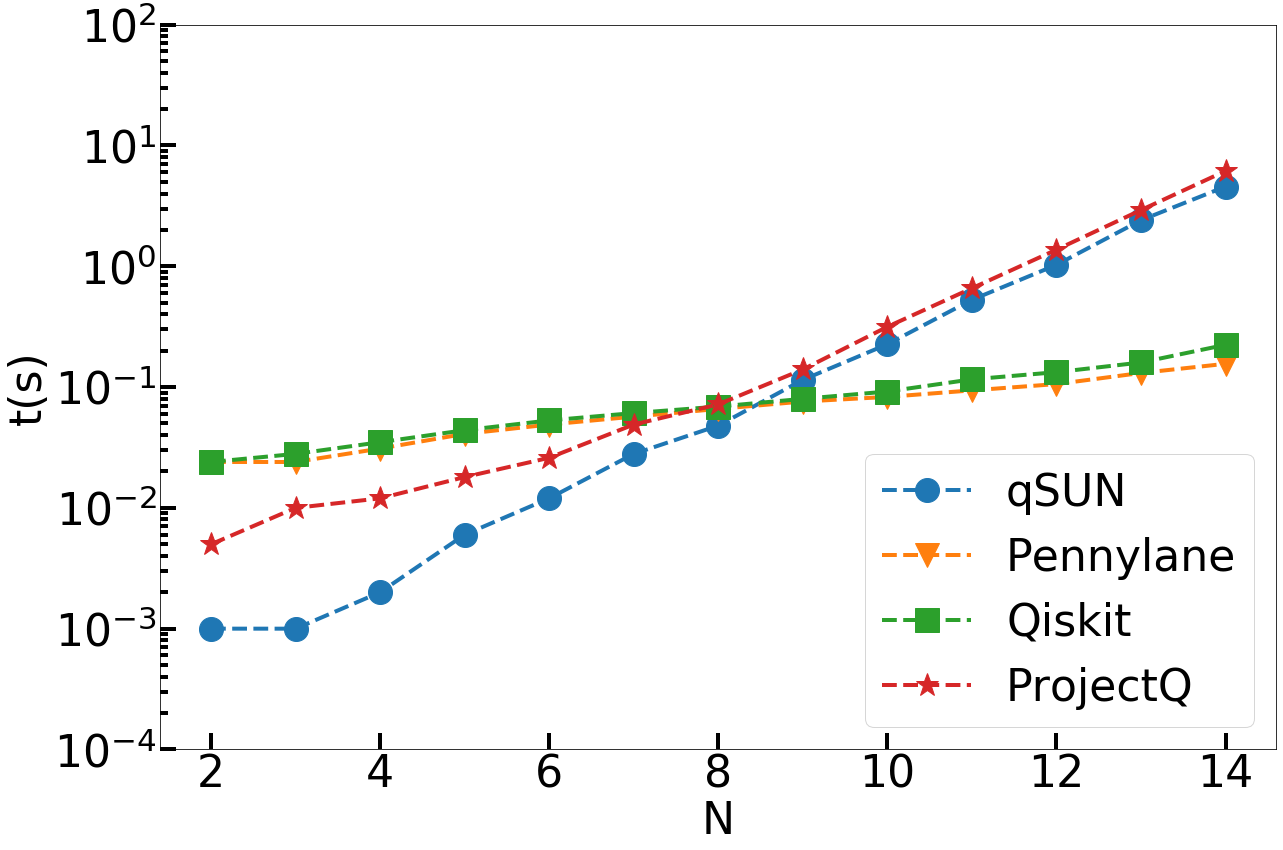

In [7]:
plt.figure(figsize=(20,13.33))
plt.tick_params(axis="x", which = 'major', direction="in", length=16, width=4)
plt.tick_params(axis="y", which = 'major', direction="in", length=16, width=4)
plt.tick_params(axis="y", which = 'minor', direction="in", length=8, width=4)
plt.plot(range(qubit_min, qubit_max), df['QVM'], 'o--', linewidth=4, markersize=24, label='qSUN')
plt.plot(range(qubit_min, qubit_max), df['PennyLane'], 'v--', linewidth=4, markersize=24, label='Pennylane')
plt.plot(range(qubit_min, qubit_max), df['Qiskit'], 's--', linewidth=4, markersize=24, label='Qiskit')
plt.plot(range(qubit_min, qubit_max), df['ProjectQ'], '*--', linewidth=4, markersize=24, label='ProjectQ')
plt.xlabel('N')
plt.yscale('log')
plt.ylim([0.0001, 100])
plt.legend(loc='lower right')
plt.ylabel('t(s)')
plt.savefig('compare.png')
plt.savefig('compare.eps', format='eps')

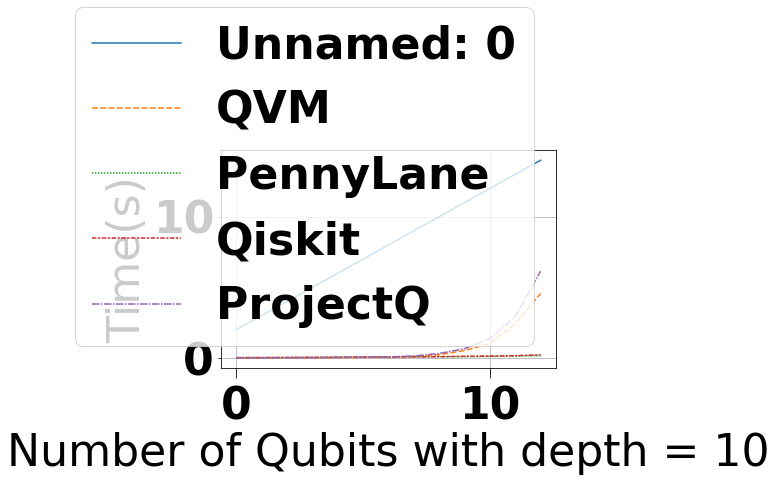

In [99]:
sns.lineplot(data = df)
plt.xlabel('Number of Qubits with depth = '+str(depth))
plt.ylabel('Time(s)')
plt.grid()
plt.savefig('compare.png')